# Apex Tracking - Live Demo

In this notebook we'll used the trained model to steer the robot around the course.

First, let's load the model we trained.

In [1]:
import torchvision
import torch
from heatmap import HeatmapModel, generate_heatmap

# model = torchvision.models.resnet18(pretrained=True)
# model.fc = torch.nn.Linear(512, 2)
model = HeatmapModel(1, [128, 128])
model.load_state_dict(torch.load('apex_obstacle_heatmap_model_2.pth'))

device = torch.device('cuda')
model = model.to(device).eval().half()

Next, we'll optimize the model using ``torch2trt``.  To do this, we feed example data as input.  We need to call ``model.eval`` before converting with torch2trt.  We'll enable ``fp16_mode`` which allow network optimizations to use reduced precision operations internally.

This may take a couple minutes...

In [2]:
import tensorrt as trt
from torch2trt import torch2trt, tensorrt_converter

In [3]:
#from torch2trt import torch2trt, tensorrt_converter, 

data = torch.zeros((1, 3, 224, 224)).cuda().half()

model_trt = torch2trt(model, [data], fp16_mode=True, max_workspace_size=1<<25)

In [4]:
model_trt.engine

We can save the model by calling the following.  This way we can re-use the optimized model without having to run the optimization procedure again.

In [4]:
torch.save(model_trt.state_dict(), 'apex_obstacle_heatmap_model_trt_half.pth')

We can save the optimized model by loading it into a TRTModule as follows.

In [3]:
import torch
from torch2trt import TRTModule

model_trt = TRTModule()
model_trt.load_state_dict(torch.load('apex_obstacle_heatmap_model_trt_half.pth'))

Next, let's create the racecar instance which we'll use to control the robot. 

In [4]:
from jetracer.nvidia_racecar import NvidiaRacecar

car = NvidiaRacecar(
    steering_gain=1.0,
    steering_offset=0.0,
    throttle_gain=-1.0,
    throttle_offset=0.0
)

And some sliders to tune parameters used for steering the robot.

In [88]:
from IPython.display import display
import ipywidgets

steering_gain = ipywidgets.FloatSlider(min=0.0, max=3.0, value=0.5, step=0.001, description='steering gain')
steering_offset = ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0.0, step=0.001, description='steering offset')
throttle_gain = ipywidgets.FloatSlider(min=0.0, max=2.0, value=1.0, step=0.001, description='throttle gain')
throttle_offset = ipywidgets.FloatSlider(min=-0.5, max=0.5, value=0.0, step=0.001, description='throttle offset')

display(
    steering_gain,
    steering_offset,
    throttle_gain,
    throttle_offset
)

FloatSlider(value=0.5, description='steering gain', max=3.0, step=0.001)

FloatSlider(value=0.0, description='steering offset', max=0.5, min=-0.5, step=0.001)

FloatSlider(value=1.0, description='throttle gain', max=2.0, step=0.001)

FloatSlider(value=0.0, description='throttle offset', max=0.5, min=-0.5, step=0.001)

In [97]:
steering_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, value=0.0, step=0.001)
throttle_slider = ipywidgets.FloatSlider(min=0.0, max=1.0, value=0.0, step=0.001)

display(steering_slider, throttle_slider)

FloatSlider(value=0.0, max=1.0, min=-1.0, step=0.001)

FloatSlider(value=0.0, max=1.0, step=0.001)

Call the following cell to initialize the camera.

In [98]:
image_widget = ipywidgets.Image(format='jpeg')

display(image_widget)

Image(value=b'', format='jpeg')

In [99]:
button = ipywidgets.ToggleButton()

display(button)

ToggleButton(value=False)

In [8]:
from jetcam.csi_camera import CSICamera
from jetcam.utils import bgr8_to_jpeg

camera = CSICamera(width=224, height=224, capture_width=1280, capture_height=720, capture_fps=60)

camera.running = True

In [92]:
import trt_pose.plugins

def get_best_peak(heatmap, thresh=0.1):
    counts, peaks = trt_pose.plugins.find_peaks(heatmap, thresh, 5, 50)
    refined_peaks = trt_pose.plugins.refine_peaks(counts, peaks, heatmap, 5)
    vals = []
    if counts[0][0] == 0:
        return None
    for i in range(counts[0][0]):
        vals.append(float(heatmap[0, 0, int(peaks[0, 0, i, 0]), int(peaks[0, 0, i, 1])]))
    idx = np.argmax(vals)
    val = vals[idx]
    peak = refined_peaks[0, 0, idx]
    return peak

In [100]:
def compute_speed(y, throttle_gain, throttle_bias):
    log_mean = 0.604
    log_std = 0.04283779825222375
    speed = np.clip(((y - log_mean) / log_std + 1.0) / 2.0, 0.0, 1.0)
    speed = np.clip(speed * throttle_gain + throttle_bias, 0.0, 0.9)
    return float(speed)

Now let's call our control loop function, which will be attached to new camera images.  This will execute the neural network and steer the car.

In [116]:
from utils import preprocess
import cv2
import numpy as np

log = []

def execute(change):
    image = change['new']
    data = preprocess(image)
    heatmap = model_trt(data).cpu().float()#.numpy()
    peak = get_best_peak(heatmap)
    if peak is not None:
        yint = int(peak[0] * 224)
        xint = int(peak[1] * 224)
        y = float(1.0 - peak[0])
        x = 2.0 * (float(peak[1]) - 0.5)
        car.steering = x * steering_gain.value + steering_offset.value
        cv2.circle(image, (xint, yint), 3, (0, 255, 0), 3)
        
        if button.value:
            log.append(y)
            
        car.throttle = compute_speed(y, throttle_gain.value, throttle_offset.value)
        throttle_slider.value = car.throttle
        
    image_widget.value = bgr8_to_jpeg(image)

We'll manually call the execution function once, which may take some time the first time the neural network is called.

We recommend disabling autonomous mode for this first execution.

In [117]:
execute({'new': camera.value})

Now, assuming the cell above executed without issue, call the following cell to attach the execute function to new camera values.

In [118]:
camera.observe(execute, names='value')

In [21]:
car.throttle = 0.2

In [120]:
camera.unobserve_all()

In [ ]:
!unzip 

In [10]:
camera.value.mean()

93.37248883928571

In [24]:
import matplotlib.pyplot as plt

In [27]:
logn = np.array(log)

In [63]:
def compute_speed(y, throttle_gain, throttle_bias):
    log_mean = 0.604
    log_std = 0.04283779825222375
    speed = np.clip(((y - log_mean) / log_std + 1.0) / 2.0, 0.0, 1.0)
    speed = np.clip(speed * throttle_gain + throttle_bias, 0.0, 0.9)
    return float(speed)

In [ ]:
compute_

In [ ]:
compute_speed()

In [64]:
np.clip(logn, 0.53, 0.7)

array([0.64885449, 0.64902675, 0.64619863, ..., 0.57506144, 0.57515824,
       0.57494998])

In [48]:
logn.mean()

0.6046046165525079

In [83]:
compute_speed(0.62, 1.0, 0.0)

0.6867509612164701

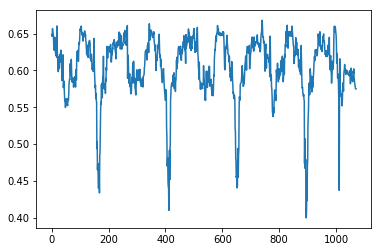

In [54]:
# plt.plot((logn - logn.min()) / (logn.max() - logn.min()))
# plt.plot(logn)
# plt.plot(np.clip(logn, 0.53, 0.66) )
plt.plot(logn)
plt.show()